<a href="https://colab.research.google.com/github/BehnamSherafat/Generating-Deterioration-Curves-for-Culverts-using-Machin-Learning/blob/main/UtahCulvertsInspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from statistics import mode
from numpy import mean
from numpy import std
from sympy import S, symbols, printing
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
from google.colab import files
uploaded = files.upload()

Saving Utah_Culverts_272_Inspection_final.xlsx to Utah_Culverts_272_Inspection_final.xlsx


In [ ]:
sns.set(rc={'figure.figsize':(25,10)})

In [ ]:
# Upload Vermont Culvert Dataset
UtahCulverts = pd.read_excel("Utah_Culverts_272_Inspection_final.xlsx")
UtahCulverts.head(5)

,Row,CvtID,RD_Route_ID,RD_Route_Num,RD_Ref_Post,RD_Accum_Mileage,RD_Average_AADT,RD_Latitude,RD_Longitude,RD_Highwy,...,WT_Flow,Road_Importance,Span_Importance,Drain_Importance,Importance_Modifier,Age,Maint_Rtg,Brl_Rtng,Wtrwy_Rtng,Rdway_Condition
0,272,360H-006-0024-05100,SR-006,6,25,24.51,401,39.08967,-113.60688,Undivided,...,Intermittent,0.91,1.00,0.91,0.83,55,6,7,6,Good
1,271,360H-006-0055-00200,SR-006,6,55,55.02,399,39.12852,-113.10622,Undivided,...,Intermittent,0.91,0.91,0.91,0.75,23,7,7,7,Fair
2,270,360H-006-0075-09800,SR-006,6,76,75.98,399,39.30673,-112.79398,Undivided,...,Intermittent,0.91,1.10,0.91,0.91,33,6,6,8,Good
3,269,360H-006-0108-03900,SR-006,6,108,108.39,1160,39.56523,-112.34710,Undivided,...,Intermittent,1.00,1.10,0.91,1.00,41,7,8,7,Good
4,268,360H-006-0124-06200,SR-006,6,125,124.62,869,39.75590,-112.18078,Undivided,...,Intermittent,1.00,1.10,0.91,1.00,41,8,8,8,Good


# Pre-processing Features

In [ ]:
UtahCulverts.loc[UtahCulverts['Maint_Rtg'] == 9, ['Age']] -= 20
UtahCulverts.loc[UtahCulverts['Maint_Rtg'] == 6, ['Age']] -= 9
UtahCulverts.loc[UtahCulverts['Maint_Rtg'] == 0, ['Age']] += 4

In [ ]:
UtahCulverts.loc[UtahCulverts['Brl_Rtng'] == 9, ['Age']] -= 2
UtahCulverts.loc[UtahCulverts['Brl_Rtng'] == 7, ['Age']] -= 5
UtahCulverts.loc[UtahCulverts['Brl_Rtng'] == 6, ['Age']] -= 3
UtahCulverts.loc[UtahCulverts['Brl_Rtng'] == 3, ['Age']] += 4

In [ ]:
UtahCulverts.loc[UtahCulverts['Wtrwy_Rtng'] == 9, ['Age']] -= 2
UtahCulverts.loc[UtahCulverts['Wtrwy_Rtng'] == 4, ['Age']] += 1

In [ ]:
# Remove Unnecessary Columns
UtahCulverts.drop(['Row', 'CvtID', 'RD_Route_Num','RD_Ref_Post','RD_Accum_Mileage','RD_Latitude','RD_Longitude','Rdway_Condition'], axis=1, inplace=True)

# Remove Unimportant Features After Feature Selction using ExtraTreeModel 
columns_to_drop = ['SL_Flooding_Frequency',
 'Span_Importance',
 'SL_EnvlpMoist',
 'CV_Drn_Type',
 'RD_Highwy',
 'Drain_Importance']
UtahCulverts.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# Fill Missing Values for Road Features (RD_)
impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['RD_Route_ID'] = impute_size.fit_transform(UtahCulverts[['RD_Route_ID']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="mean") 
UtahCulverts['RD_Average_AADT'] = impute_size.fit_transform(UtahCulverts[['RD_Average_AADT']])

# impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
# UtahCulverts['RD_Highwy'] = impute_size.fit_transform(UtahCulverts[['RD_Highwy']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="mean") 
UtahCulverts['RD_Rdwy_Cvr_in'] = impute_size.fit_transform(UtahCulverts[['RD_Rdwy_Cvr_in']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['RD_Surface_Type'] = impute_size.fit_transform(UtahCulverts[['RD_Surface_Type']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['RD_Region'] = impute_size.fit_transform(UtahCulverts[['RD_Region']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['RD_ShldrSurfacType'] = impute_size.fit_transform(UtahCulverts[['RD_ShldrSurfacType']])


# Fill Missing Values for Culvert Features (CV_)
# impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
# UtahCulverts['CV_Drn_Type'] = impute_size.fit_transform(UtahCulverts[['CV_Drn_Type']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_IltEndTrtmnt'] = impute_size.fit_transform(UtahCulverts[['CV_IltEndTrtmnt']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_IltSide'] = impute_size.fit_transform(UtahCulverts[['CV_IltSide']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_OtltEndTrtmnt'] = impute_size.fit_transform(UtahCulverts[['CV_OtltEndTrtmnt']])

impute_size = SimpleImputer(strategy="most_frequent") 
UtahCulverts['CV_OtltSide'] = impute_size.fit_transform(UtahCulverts[['CV_OtltSide']])

impute_size = SimpleImputer(strategy="most_frequent") 
UtahCulverts['CV_Brl_Count'] = impute_size.fit_transform(UtahCulverts[['CV_Brl_Count']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="mean") 
UtahCulverts['CV_Brl_Length_ft'] = impute_size.fit_transform(UtahCulverts[['CV_Brl_Length_ft']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_Barrel_Material'] = impute_size.fit_transform(UtahCulverts[['CV_Barrel_Material']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_Brl_Shape'] = impute_size.fit_transform(UtahCulverts[['CV_Brl_Shape']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_Span_in'] = impute_size.fit_transform(UtahCulverts[['CV_Span_in']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_Brl_Rise'] = impute_size.fit_transform(UtahCulverts[['CV_Brl_Rise']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_Brl_Coat_Type'] = impute_size.fit_transform(UtahCulverts[['CV_Brl_Coat_Type']])


# Fill Missing Values for Soil Features (SL_)
impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_Envlp_Type'] = impute_size.fit_transform(UtahCulverts[['SL_Envlp_Type']])

# impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
# UtahCulverts['SL_EnvlpMoist'] = impute_size.fit_transform(UtahCulverts[['SL_EnvlpMoist']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_Drainage_Class'] = impute_size.fit_transform(UtahCulverts[['SL_Drainage_Class']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="mean") 
UtahCulverts['SL_Moisture'] = impute_size.fit_transform(UtahCulverts[['SL_Moisture']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="mean") 
UtahCulverts['SL_pH'] = impute_size.fit_transform(UtahCulverts[['SL_pH']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="mean") 
UtahCulverts['SL_Elec_Conductivity'] = impute_size.fit_transform(UtahCulverts[['SL_Elec_Conductivity']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_Surface_Texture'] = impute_size.fit_transform(UtahCulverts[['SL_Surface_Texture']])

# impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
# UtahCulverts['SL_Flooding_Frequency'] = impute_size.fit_transform(UtahCulverts[['SL_Flooding_Frequency']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_UpstrmBnkProtct'] = impute_size.fit_transform(UtahCulverts[['SL_UpstrmBnkProtct']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_DnstrmBnkProtct'] = impute_size.fit_transform(UtahCulverts[['SL_DnstrmBnkProtct']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_VegIndx'] = impute_size.fit_transform(UtahCulverts[['SL_VegIndx']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_Revegetation_Zone'] = impute_size.fit_transform(UtahCulverts[['SL_Revegetation_Zone']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_Geologic_Zone'] = impute_size.fit_transform(UtahCulverts[['SL_Geologic_Zone']])


# Fill Missing Values for Water Features (WT_)
impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['WT_Flow'] = impute_size.fit_transform(UtahCulverts[['WT_Flow']])

# Fill Missing Values for Importance Features
impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['Road_Importance'] = impute_size.fit_transform(UtahCulverts[['Road_Importance']])

# impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
# UtahCulverts['Span_Importance'] = impute_size.fit_transform(UtahCulverts[['Span_Importance']])

# impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
# UtahCulverts['Drain_Importance'] = impute_size.fit_transform(UtahCulverts[['Drain_Importance']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['Importance_Modifier'] = impute_size.fit_transform(UtahCulverts[['Importance_Modifier']])

# Fill Missing Values for Condition Features
impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['Maint_Rtg'] = impute_size.fit_transform(UtahCulverts[['Maint_Rtg']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['Brl_Rtng'] = impute_size.fit_transform(UtahCulverts[['Brl_Rtng']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['Wtrwy_Rtng'] = impute_size.fit_transform(UtahCulverts[['Wtrwy_Rtng']])

In [ ]:
# Modify Type of each Column
UtahCulverts["RD_Average_AADT"] = UtahCulverts["RD_Average_AADT"].astype(int)
UtahCulverts["RD_Rdwy_Cvr_in"] = UtahCulverts["RD_Rdwy_Cvr_in"].astype(int)
UtahCulverts["RD_Region"] = UtahCulverts["RD_Region"].astype(int)
UtahCulverts["CV_Brl_Count"] = UtahCulverts["CV_Brl_Count"].astype(int)
UtahCulverts["CV_Brl_Length_ft"] = UtahCulverts["CV_Brl_Length_ft"].astype(int)
UtahCulverts["CV_Span_in"] = UtahCulverts["CV_Span_in"].astype(int)
UtahCulverts["CV_Brl_Rise"] = UtahCulverts["CV_Brl_Rise"].astype(int)
UtahCulverts["Age"] = UtahCulverts["Age"].astype(int)
UtahCulverts["Maint_Rtg"] = UtahCulverts["Maint_Rtg"].astype(int)
UtahCulverts["Brl_Rtng"] = UtahCulverts["Brl_Rtng"].astype(int)
UtahCulverts["Wtrwy_Rtng"] = UtahCulverts["Wtrwy_Rtng"].astype(int)

UtahCulverts['RD_Route_ID'] = UtahCulverts['RD_Route_ID'].astype('category')
# UtahCulverts['RD_Highwy'] = UtahCulverts['RD_Highwy'].astype('category')                                                              
UtahCulverts['RD_Surface_Type'] = UtahCulverts['RD_Surface_Type'].astype('category')                                                              
UtahCulverts['RD_ShldrSurfacType'] = UtahCulverts['RD_ShldrSurfacType'].astype('category')                                                              
# UtahCulverts['CV_Drn_Type'] = UtahCulverts['CV_Drn_Type'].astype('category')                                                              
UtahCulverts['CV_IltEndTrtmnt'] = UtahCulverts['CV_IltEndTrtmnt'].astype('category')                                                              
UtahCulverts['CV_IltSide'] = UtahCulverts['CV_IltSide'].astype('category')                                                              
UtahCulverts['CV_OtltEndTrtmnt'] = UtahCulverts['CV_OtltEndTrtmnt'].astype('category')                                                              
UtahCulverts['CV_OtltSide'] = UtahCulverts['CV_OtltSide'].astype('category')                                                              
UtahCulverts['CV_Barrel_Material'] = UtahCulverts['CV_Barrel_Material'].astype('category')  
UtahCulverts['CV_Brl_Shape'] = UtahCulverts['CV_Brl_Shape'].astype('category')                                                            
UtahCulverts['CV_Brl_Coat_Type'] = UtahCulverts['CV_Brl_Coat_Type'].astype('category')                                                                                                                           
UtahCulverts['SL_Envlp_Type'] = UtahCulverts['SL_Envlp_Type'].astype('category')
# UtahCulverts['SL_EnvlpMoist'] = UtahCulverts['SL_EnvlpMoist'].astype('category')
UtahCulverts['SL_Drainage_Class'] = UtahCulverts['SL_Drainage_Class'].astype('category')
UtahCulverts['SL_Surface_Texture'] = UtahCulverts['SL_Surface_Texture'].astype('category')
# UtahCulverts['SL_Flooding_Frequency'] = UtahCulverts['SL_Flooding_Frequency'].astype('category')
UtahCulverts['SL_UpstrmBnkProtct'] = UtahCulverts['SL_UpstrmBnkProtct'].astype('category')
UtahCulverts['SL_DnstrmBnkProtct'] = UtahCulverts['SL_DnstrmBnkProtct'].astype('category')
UtahCulverts['SL_VegIndx'] = UtahCulverts['SL_VegIndx'].astype('category')
UtahCulverts['SL_Revegetation_Zone'] = UtahCulverts['SL_Revegetation_Zone'].astype('category')
UtahCulverts['SL_Geologic_Zone'] = UtahCulverts['SL_Geologic_Zone'].astype('category')
UtahCulverts['WT_Flow'] = UtahCulverts['WT_Flow'].astype('category')

In [ ]:
## First Approach (Mapping Column Values to Other Columns)
tempdf = pd.get_dummies(UtahCulverts["RD_Route_ID"], prefix='RD_Route_ID')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["RD_Route_ID"], axis=1, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["RD_Surface_Type"], prefix='RD_Surface_Type')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["RD_Surface_Type"], axis=1, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["RD_Region"], prefix='RD_Region')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["RD_Region"], axis=1, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["RD_ShldrSurfacType"], prefix='RD_ShldrSurfacType')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["RD_ShldrSurfacType"], axis=1, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["CV_IltEndTrtmnt"], prefix='CV_IltEndTrtmnt')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["CV_IltEndTrtmnt"], axis=1, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["CV_IltSide"], prefix='CV_IltSide')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["CV_IltSide"], axis=1, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["CV_OtltEndTrtmnt"], prefix='CV_OtltEndTrtmnt')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["CV_OtltEndTrtmnt"], axis=1, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["CV_OtltSide"], prefix='CV_OtltSide')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["CV_OtltSide"], axis=1, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["CV_Barrel_Material"], prefix='CV_Barrel_Material')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["CV_Barrel_Material"], axis=1, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["CV_Brl_Shape"], prefix='CV_Brl_Shape')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["CV_Brl_Shape"], axis=1, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["CV_Brl_Coat_Type"], prefix='CV_Brl_Coat_Type')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["CV_Brl_Coat_Type"], axis=1, inplace=True)

replace_map_comp = {'Very Poorly Drained': 0,
                    'Poorly Drained': 1,
                    'Somewhat Poorly Drained': 2,
                    'Moderately Well Drained': 3,
                    'Well Drained': 4,
                    'Somewhat Excessively Drained': 5,
                    'Excessively Drained': 6}
 
UtahCulverts.replace({"SL_Drainage_Class": replace_map_comp}, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["SL_Surface_Texture"], prefix='SL_Surface_Texture')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["SL_Surface_Texture"], axis=1, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["SL_Envlp_Type"], prefix='SL_Envlp_Type')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["SL_Envlp_Type"], axis=1, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["SL_UpstrmBnkProtct"], prefix='SL_UpstrmBnkProtct')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["SL_UpstrmBnkProtct"], axis=1, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["SL_DnstrmBnkProtct"], prefix='SL_DnstrmBnkProtct')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["SL_DnstrmBnkProtct"], axis=1, inplace=True)

replace_map_comp = {'No vegetation': 0,
                    'Little': 1,
                    'Moderately': 2,
                    'Fully': 3}
 
UtahCulverts.replace({"SL_VegIndx": replace_map_comp}, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["SL_Revegetation_Zone"], prefix='SL_Revegetation_Zone')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["SL_Revegetation_Zone"], axis=1, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["SL_Geologic_Zone"], prefix='SL_Geologic_Zone')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["SL_Geologic_Zone"], axis=1, inplace=True)

tempdf = pd.get_dummies(UtahCulverts["WT_Flow"], prefix='WT_Flow')
UtahCulverts = pd.merge(left=UtahCulverts, right=tempdf, left_index=True, right_index=True)
UtahCulverts.drop(["WT_Flow"], axis=1, inplace=True)


# Update Conditions from 10-point rating to 5-point rating

In [ ]:
Condition_Values = {0:0,
                    1:0,
                    2:1,
                    3:1,
                    4:2,
                    5:2,
                    6:3,
                    7:3,
                    8:4,
                    9:4}

UtahCulverts['Maint_Rtg'] = UtahCulverts.Maint_Rtg.replace(Condition_Values)
UtahCulverts['Brl_Rtng'] = UtahCulverts.Brl_Rtng.replace(Condition_Values)
UtahCulverts['Wtrwy_Rtng'] = UtahCulverts.Wtrwy_Rtng.replace(Condition_Values)

# **Maintenance Rating**

In [ ]:
X = UtahCulverts.drop(['Maint_Rtg','Brl_Rtng','Wtrwy_Rtng'], axis = 1)
y = UtahCulverts['Maint_Rtg']

In [ ]:
sm = SMOTE(sampling_strategy='not majority', random_state=42)
X_re, Y_re = sm.fit_resample(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_re, Y_re, test_size=0.1, random_state=42)

In [ ]:
param = {'kernel' : ['rbf'],'C' : [1,5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')},

svr_model = SVR()

svr_grid = GridSearchCV(estimator=svr_model, param_grid=param, cv=3, verbose=4, n_jobs=-1)
svr_grid.fit(X_train, y_train)
svr_grid.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


{'C': 10, 'coef0': 0.01, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}

In [ ]:
#model = RandomForestRegressor(n_estimators = 400, max_depth=10, random_state = 42, bootstrap=False, n_jobs=-1)
#model.fit(X_train, y_train) 

# model = make_pipeline(StandardScaler(), SVR(kernel="rbf", degree=3,coef0=0.01, C=10, epsilon=0.2, gamma= 'auto'))
# model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=10, coef0=0.01, epsilon=0.2, gamma='auto'))])

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_
model= rf_random.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

Mean Sqaured Error on test data is:  0.397625504032258
Coefficient of Determination (R2) on test data is:  0.8006686962050078
[[2.     4.     3.     0.     4.     4.     2.     0.     0.     2.
  0.     1.     3.     0.     3.     1.     4.     1.     2.     1.
  0.     0.     2.     0.     2.     2.     2.     1.     2.     4.
  3.     3.     1.     2.     3.     1.     3.     0.     4.     1.
  4.     1.     3.     0.     0.     4.     2.     1.     0.     0.
  4.     1.     1.     0.     4.     3.     4.     2.     0.     2.
  2.     1.    ]
 [2.3225 1.9275 1.585  0.0525 3.0025 2.59   2.28   0.2175 0.0175 2.6825
  0.0525 1.1075 2.615  0.8975 3.1    2.715  3.7975 1.145  2.7775 1.01
  0.27   1.23   2.815  0.015  3.0925 2.     2.365  1.05   2.2375 2.8375
  2.5425 2.41   1.3025 2.39   2.8325 1.08   3.085  0.4425 3.1425 1.5
  3.815  1.     2.51   0.     0.1275 3.625  2.2725 1.3575 0.02   0.3325
  3.6775 1.3375 1.7075 0.125  3.01   2.6475 3.69   2.62   0.01   2.
  2.075  1.0875]]


(0.0, 4.0)

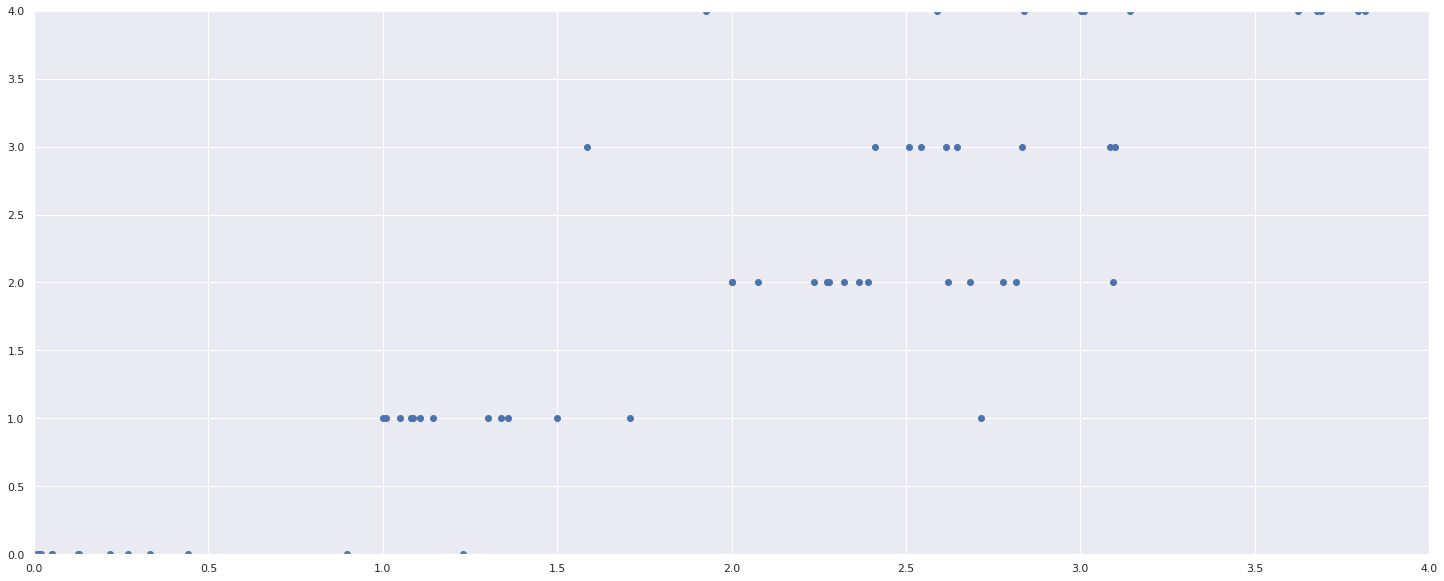

In [ ]:
#Random forest
model= rf_random.best_estimator_
model.fit(X_train, y_train)
model_name= "RF"
#SVR
# model = make_pipeline(StandardScaler(), SVR(kernel="rbf", degree=3,coef0=0.01, C=10, epsilon=0.2, gamma= 'auto'))
# model.fit(X_train, y_train)
# model_name= "SVR"

y_pred = model.predict(X_test)
errors = mean_squared_error(y_test, y_pred)
Coefficient_of_determination = r2_score(y_test, y_pred)
print(f"Mean Sqaured Error on test data is:  {errors}")
print(f"Coefficient of Determination (R2) on test data is:  {Coefficient_of_determination}")
data = np.array([list(y_test),
                 list(y_pred)])
print(data)
plt.scatter(y_pred, y_test)
plt.xlim([0, 4])
plt.ylim([0, 4])

In [ ]:
# Generate Synthetic Dataset for Test
culverts_test = X_re.copy()

culverts_test['CV_Barrel_Material_Corrugated Steel'] = 1
culverts_test['CV_Barrel_Material_Steel Plate'] = 0
culverts_test['CV_Barrel_Material_Reinforced Concrete'] = 0
culverts_test['CV_Barrel_Material_High Density Polyethylene'] = 0
culverts_test['CV_Barrel_Material_Unreinforced Concrete'] = 0
culverts_test['CV_Barrel_Material_Poly Vinyl Chloride'] = 0
culverts_test['CV_Barrel_Material_Timber'] = 0
culverts_test['CV_Barrel_Material_Aluminum'] = 0

culverts_test['RD_Region_1'] = 0
culverts_test['RD_Region_2'] = 0
culverts_test['RD_Region_3'] = 0
culverts_test['RD_Region_4'] = 1

# culverts_test = culverts_test.drop(['Maint_Rtg','Brl_Rtng','Wtrwy_Rtng'],axis = 1)

In [ ]:
culverts_test

,RD_Average_AADT,RD_Rdwy_Cvr_in,CV_Brl_Count,CV_Brl_Length_ft,CV_Span_in,CV_Brl_Rise,SL_Drainage_Class,SL_Moisture,SL_pH,SL_Elec_Conductivity,...,SL_Geologic_Zone_Quaternary,SL_Geologic_Zone_Quaternary Mud Flats,SL_Geologic_Zone_Tertiary (older),SL_Geologic_Zone_Tertiary (younger),SL_Geologic_Zone_Tertiary Volcanics,SL_Geologic_Zone_Triassic,WT_Flow_Ephemeral,WT_Flow_Intermittent,WT_Flow_Perennial,WT_Flow_Standing
0,401,4,1,77,36,36,5,5.600000,8.500000,2.000000,...,0,0,0,0,0,0,0,1,0,0
1,399,5,1,67,60,60,4,7.400000,8.900000,18.000000,...,1,0,0,0,0,0,0,1,0,0
2,399,3,1,60,24,24,0,0.000000,8.500000,24.000000,...,1,0,0,0,0,0,0,1,0,0
3,1160,3,1,50,24,24,4,10.800000,8.900000,1.000000,...,1,0,0,0,0,0,0,1,0,0
4,869,25,1,68,24,24,4,9.900000,8.800000,4.300000,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,6971,7,1,90,52,52,4,11.495000,8.139082,4.187755,...,0,0,0,0,0,0,0,0,0,0
616,3593,3,1,68,52,52,4,10.705690,8.311429,2.182856,...,0,0,0,0,0,0,0,1,0,0
617,103,3,1,62,37,31,2,10.950243,8.500000,17.301053,...,0,0,0,0,0,0,0,0,0,0
618,17135,6,1,73,54,59,3,12.639726,8.769478,7.097092,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
max_age = 85
ages = list(range(2, max_age, 2))
conditions = [0] * len(ages)

i = 0
for age in ages:
  culverts_test['Age'] = age
  age_conditions = model.predict(culverts_test)
  # if 0 <= age <= 30:
  #   conditions[i] = np.percentile(age_conditions, 75)
  # if 30 < age <= 60:
  #   conditions[i] = np.percentile(age_conditions, 50)
  # if 60 < age:
  #   conditions[i] = np.percentile(age_conditions, 25)
  conditions[i] = np.percentile(age_conditions, 50)

  i += 1

In [ ]:
def polyfit_with_fixed_points(n, x, y, xf, yf) :
    mat = np.empty((n + 1 + len(xf),) * 2)
    vec = np.empty((n + 1 + len(xf),))
    x_n = x**np.arange(2 * n + 1)[:, None]
    yx_n = np.sum(x_n[:n + 1] * y, axis=1)
    x_n = np.sum(x_n, axis=1)
    idx = np.arange(n + 1) + np.arange(n + 1)[:, None]
    mat[:n + 1, :n + 1] = np.take(x_n, idx)
    xf_n = xf**np.arange(n + 1)[:, None]
    mat[:n + 1, n + 1:] = xf_n / 2
    mat[n + 1:, :n + 1] = xf_n.T
    mat[n + 1:, n + 1:] = 0
    vec[:n + 1] = yx_n
    vec[n + 1:] = yf
    params = np.linalg.solve(mat, vec)
    return params[:n + 1]

(0.0, 4.0)

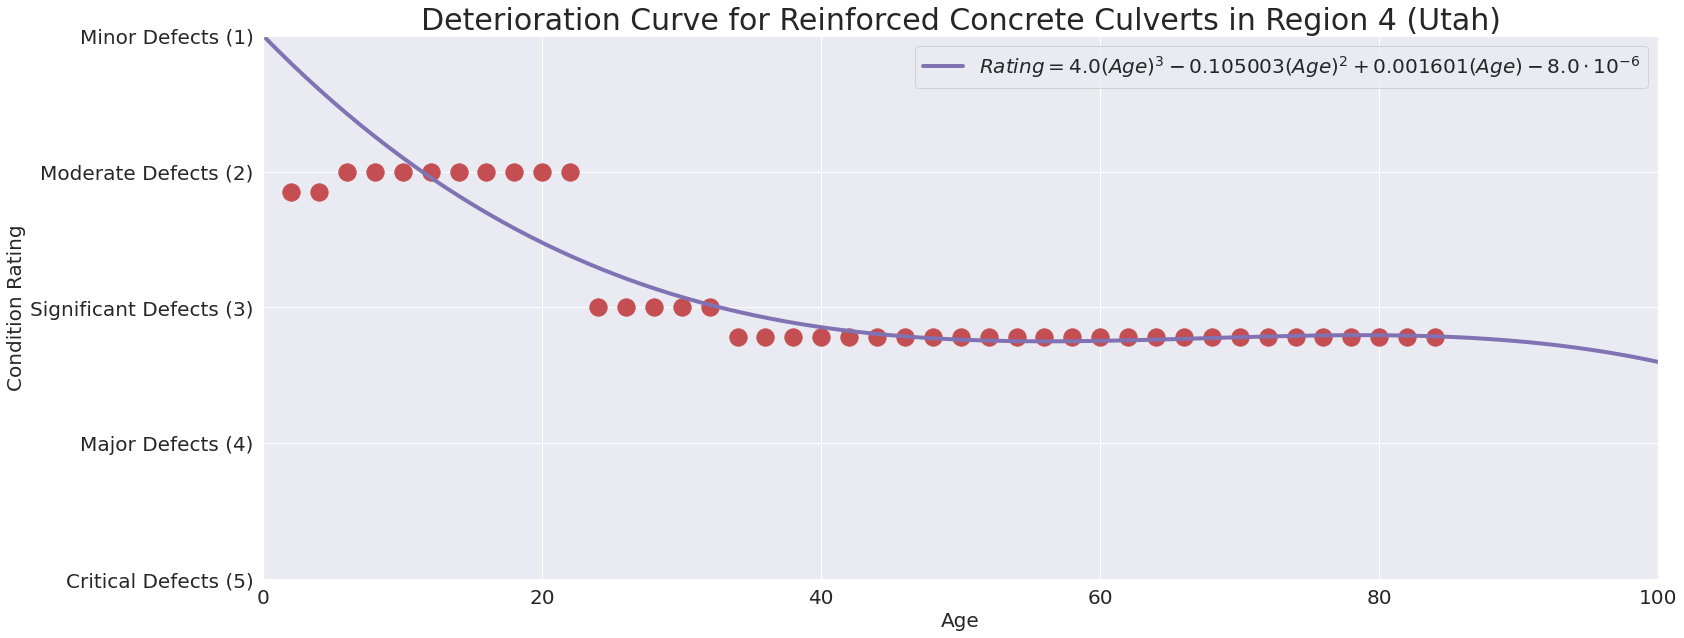

In [ ]:
label_size = 20

x = ages
y = conditions

mymodel1 = polyfit_with_fixed_points(3, x , y, [0], [4])
poly1 = np.polynomial.Polynomial(mymodel1)

# mymodel2 = np.polyfit(x, y, 3)
# poly2 = np.poly1d(mymodel2)

x1 = symbols("(Age)")
poly = sum(S("{:6.6f}".format(v))*x1**i for i, v in enumerate(mymodel1[::-1]))
eq_latex = "Rating=" + printing.latex(poly) 

myline = np.linspace(0, 100, 100)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, c='r', s=300)
# ax1.scatter([0], [4], c='r', s=300)
plt.plot(myline, poly1(myline),'m', linewidth=4, label="${}$".format(eq_latex))
plt.legend(prop={'size': label_size})
# Add title and axis names
plt.title('Deterioration Curve for Reinforced Concrete Culverts in Region 4 (Utah)',fontsize=30)
plt.xlabel('Age')
plt.ylabel('Condition Rating')
axes = plt.gca()
axes.xaxis.label.set_size(label_size)
plt.xticks(fontsize=label_size)
axes.yaxis.label.set_size(label_size)
y1 = [0,1,2,3,4]
squad = ["Critical Defects (5)", "Major Defects (4)", "Significant Defects (3)", "Moderate Defects (2)", "Minor Defects (1)"]
axes.set_yticks(y1)
axes.set_yticklabels(squad, minor=False, Fontsize=label_size)
plt.xlim([0, 100])
plt.ylim([0, 4])

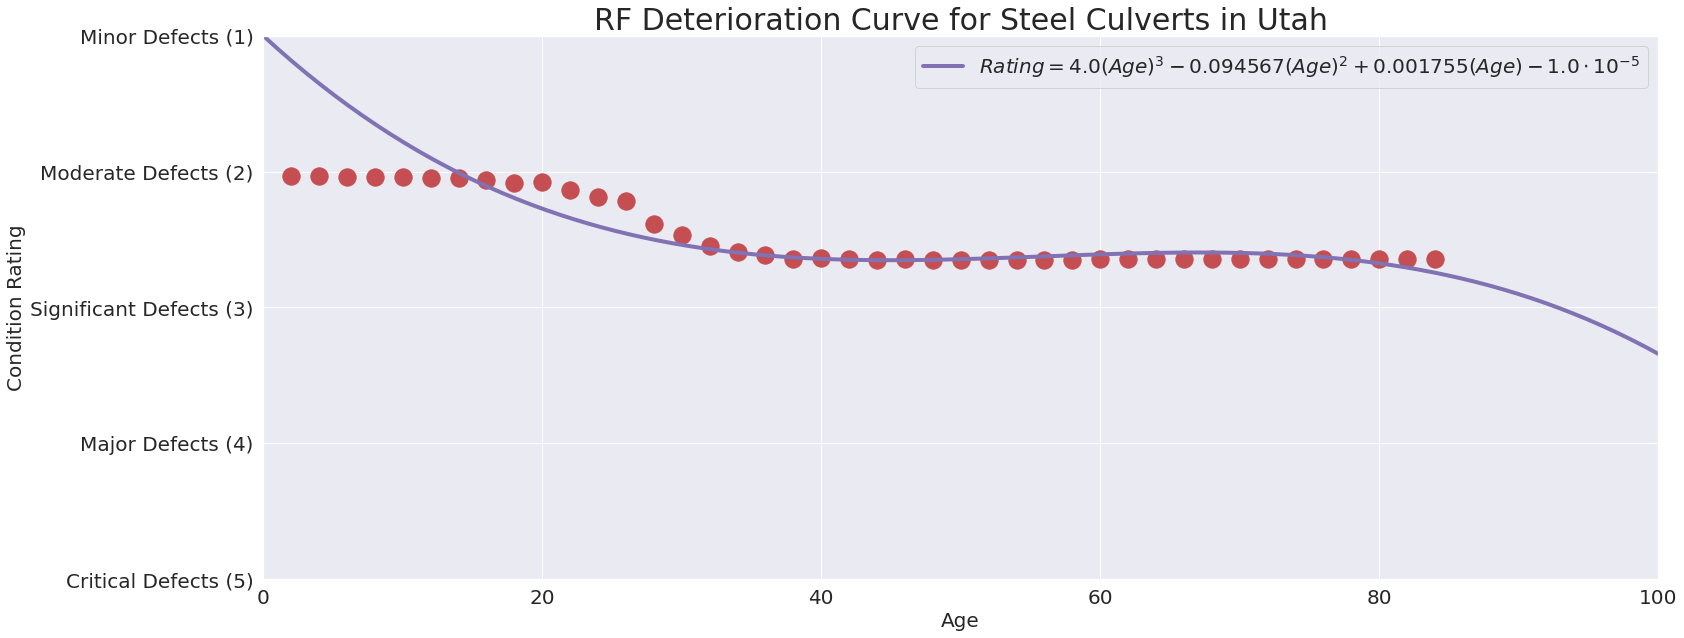

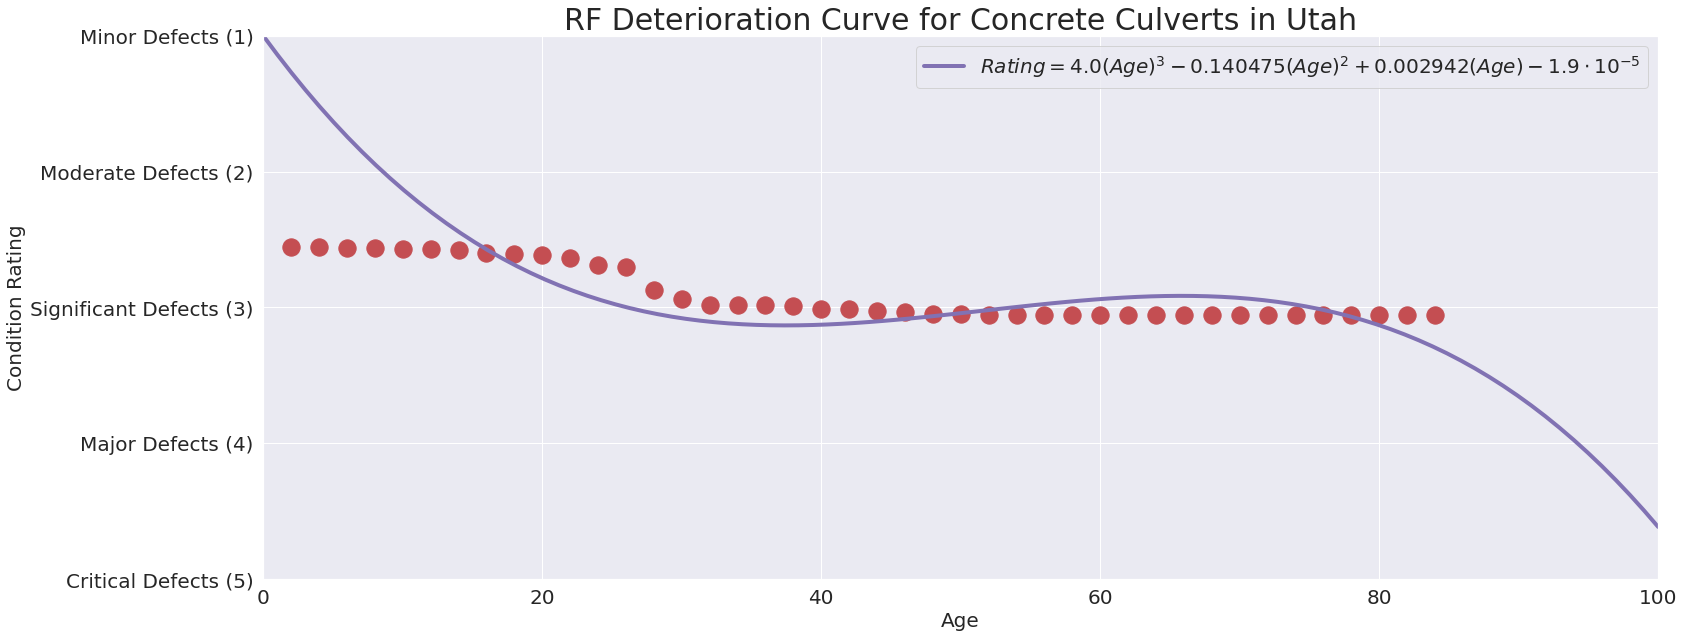

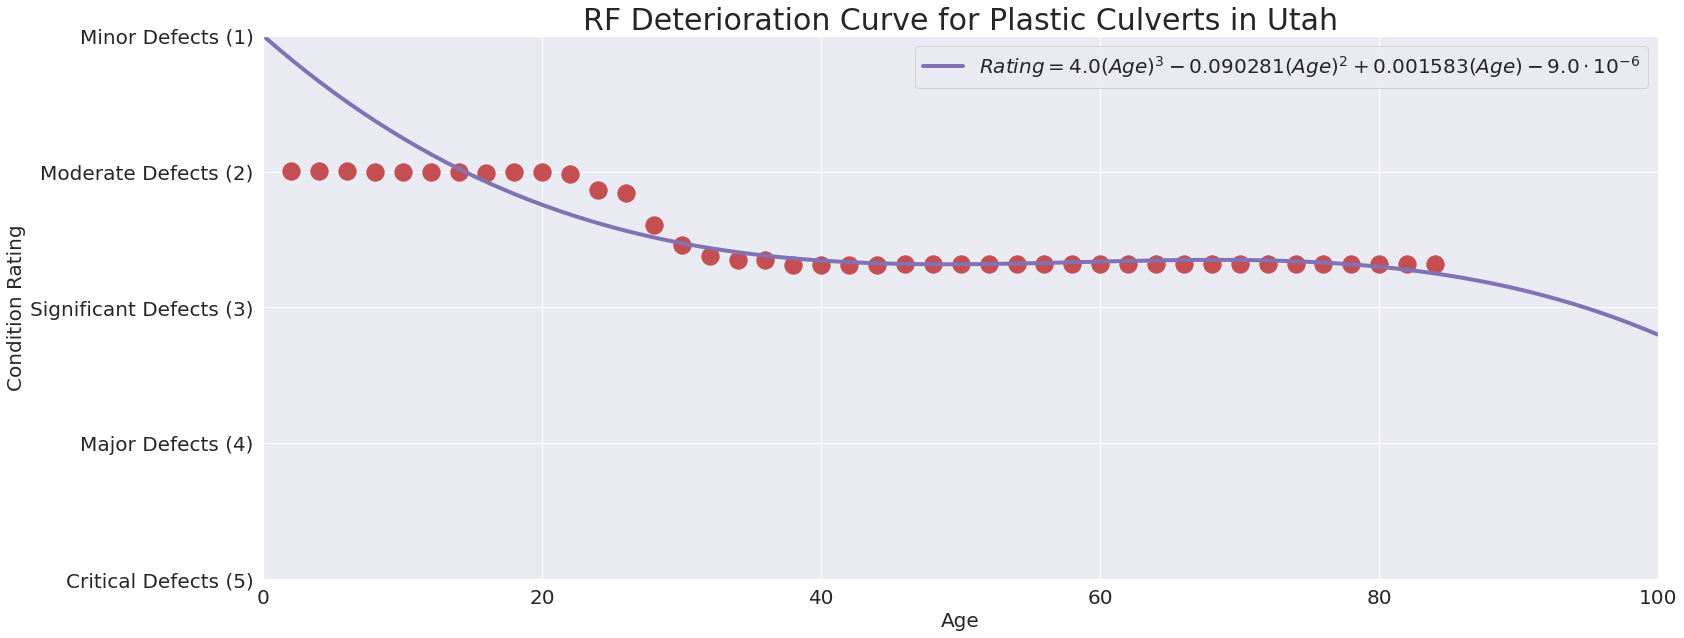

In [ ]:
for material_num in range(1,4):
    # for region in range(1,5):
        # Generate Synthetic Dataset for Test
        culverts_test = X_re.copy()
        if  material_num ==1:
            culverts_test = culverts_test.loc[(culverts_test['CV_Barrel_Material_Corrugated Steel'] == 1) | (culverts_test['CV_Barrel_Material_Steel Plate'] == 1)]
            material = "Steel"
        elif material_num ==2:
            culverts_test = culverts_test.loc[(culverts_test['CV_Barrel_Material_Reinforced Concrete'] == 1) | (culverts_test['CV_Barrel_Material_Unreinforced Concrete'] == 1)]
            material = "Concrete"
        else:
            culverts_test = culverts_test.loc[(culverts_test['CV_Barrel_Material_High Density Polyethylene'] == 1) | (culverts_test['CV_Barrel_Material_Poly Vinyl Chloride'] == 1)]
            material = "Plastic"
        
        # if region ==1:
        #     culverts_test['RD_Region_1'] = 0
        #     reg_id = "RD_Region_1"
        # elif region ==2:
        #     culverts_test['RD_Region_2'] = 0
        #     reg_id = "RD_Region_2"
        # elif region ==3:
        #     culverts_test['RD_Region_3'] = 0
        #     reg_id = "RD_Region_3"
        # else:
        #     culverts_test['RD_Region_4'] = 1
        #     reg_id = "RD_Region_4"
        
        # culverts_test = culverts_test.drop(['Maint_Rtg','Brl_Rtng','Wtrwy_Rtng'],axis = 1)
                
        max_age = 85
        ages = list(range(2, max_age, 2))
        conditions = [0] * len(ages)
        
        i = 0
        for age in ages:
          culverts_test['Age'] = age
          age_conditions = model.predict(culverts_test)
          # if 0 <= age <= 30:
          #   conditions[i] = np.percentile(age_conditions, 75)
          # if 30 < age <= 60:
          #   conditions[i] = np.percentile(age_conditions, 50)
          # if 60 < age:
          #   conditions[i] = np.percentile(age_conditions, 25)
          conditions[i] = np.percentile(age_conditions, 50)
        
          i += 1
        
        def polyfit_with_fixed_points(n, x, y, xf, yf) :
            mat = np.empty((n + 1 + len(xf),) * 2)
            vec = np.empty((n + 1 + len(xf),))
            x_n = x**np.arange(2 * n + 1)[:, None]
            yx_n = np.sum(x_n[:n + 1] * y, axis=1)
            x_n = np.sum(x_n, axis=1)
            idx = np.arange(n + 1) + np.arange(n + 1)[:, None]
            mat[:n + 1, :n + 1] = np.take(x_n, idx)
            xf_n = xf**np.arange(n + 1)[:, None]
            mat[:n + 1, n + 1:] = xf_n / 2
            mat[n + 1:, :n + 1] = xf_n.T
            mat[n + 1:, n + 1:] = 0
            vec[:n + 1] = yx_n
            vec[n + 1:] = yf
            params = np.linalg.solve(mat, vec)
            return params[:n + 1]
        
        label_size = 20
        
        x = ages
        y = conditions
        
        mymodel1 = polyfit_with_fixed_points(3, x , y, [0], [4])
        poly1 = np.polynomial.Polynomial(mymodel1)
        
        # mymodel1 = np.polyfit(x, y, 3)
        # poly1 = np.poly1d(mymodel1)
        
        x1 = symbols("(Age)")
        poly = sum(S("{:6.6f}".format(v))*x1**i for i, v in enumerate(mymodel1[::-1]))
        eq_latex = "Rating=" + printing.latex(poly) 
        
        myline = np.linspace(0, 100, 100)
        
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        
        ax1.scatter(x, y, c='r', s=300)
        # ax1.scatter([0], [4], c='r', s=300)
        plt.plot(myline, poly1(myline),'m', linewidth=4, label="${}$".format(eq_latex))
        plt.legend(prop={'size': label_size})
        # Add title and axis names
        title = model_name + ' Deterioration Curve for ' + material + ' Culverts in Utah'
        plt.title( title ,fontsize=30)
        plt.xlabel('Age')
        plt.ylabel('Condition Rating')
        axes = plt.gca()
        axes.xaxis.label.set_size(label_size)
        plt.xticks(fontsize=label_size)
        axes.yaxis.label.set_size(label_size)
        y1 = [0,1,2,3,4]
        squad = ["Critical Defects (5)", "Major Defects (4)", "Significant Defects (3)", "Moderate Defects (2)", "Minor Defects (1)"]
        axes.set_yticks(y1)
        axes.set_yticklabels(squad, minor=False, Fontsize=label_size)
        plt.xlim([0, 100])
        plt.ylim([0, 4])
        plt.show()